<a href="https://colab.research.google.com/github/Mrityunjay59/flipppkartgridd4.0/blob/main/flipkArt_ecommerce_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [78]:
import numpy as np
import pandas as pd
import ast
import plotly.express as px
from plotly import graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn import metrics


In [79]:
#converting csv file to pandas file.

df = pd.read_csv("/content/flipkart_com-ecommerce_sample.csv")

flip_kart_data = pd.read_csv('/content/Untitled spreadsheet - Train.csv')


In [80]:
#Let's see if we have any missing values.
df.isnull().sum()

uniq_id                       0
crawl_timestamp               0
product_url                   0
product_name                  0
product_category_tree         0
pid                           0
retail_price                 78
discounted_price             78
image                         3
is_FK_Advantage_product       0
description                   2
product_rating                0
overall_rating                0
brand                      5864
product_specifications       14
dtype: int64

In [81]:
df["retail_price"].fillna(df["retail_price"].median(),inplace=True)
df["discounted_price"].fillna(df["discounted_price"].median(),inplace=True)

In [82]:
# now i am adding another column to our dataset discount_percentage
x=df['retail_price']-df['discounted_price']
y=(x/df['retail_price'])*100
df['discount_percentage']=y


In [83]:
#To make working with this dataset easy, 
#extract some more columns like Time date and lastly main_category with the help of the columns crawl_timestamp and product_category_tree
df['timestamp']=pd.to_datetime(df['crawl_timestamp'])  #converting into datetime to extract date and time easily
df['Time']=df['timestamp'].apply(lambda x : x.time)  #extracting time
df['date']=df['timestamp'].apply(lambda x : x.date)  #extracting date
df.drop(['crawl_timestamp'], axis = 1,inplace=True)  #dropping the column
df['main_category']=df['product_category_tree'].apply(lambda x :x.split('>>')[0][2:len(x.split('>>')[0])-1])  #new column using product_category_tree

In [84]:
#It's important to note that out of the total product_rating in our dataset, how many  rows have relevant ratings in them.
# This leaves out a huge chunk of data

# Top 10 main products being purchased

n = 10
top_products=pd.DataFrame(df['main_category'].value_counts()  [:n]).reset_index()
top_products.rename(columns = {'index':'Top_Products','main_category':'Total_Count'}, inplace = True)

#Top 10 main brands being purchased

n = 10
top_brands=pd.DataFrame(df['brand'].value_counts()[:n]).reset_index()
top_brands.rename(columns = {'index':'Top_Brands','brand':'Total_Count'}, inplace = True)

#We have successfully created two separate dataframes, 
#namely, top_products and top_brands which contain the first 10 most frequently purchased products from flipkart.

In [85]:
# Now we will visualize and see what these dataframes tell us.
from plotly.subplots import make_subplots #plotly library to create subplots

label1 = top_products['Top_Products']
value1=top_products['Total_Count']
label2=top_brands['Top_Brands']
value2=top_brands['Total_Count']

# Create subplots

fig_both = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]])
fig_both.add_trace(go.Pie(labels=label1, values=value1, name="Top Products",pull=[0.3, 0, 0, 0]),
              1, 1)
fig_both.add_trace(go.Pie(labels=label2, values=value2, name="Top Brands",pull=[0.3, 0, 0, 0]),
              1, 2)

# Use `hole` to create a donut-like pie chart

fig_both.update_traces(hole=.4, hoverinfo="label+percent+name")
#fig_both.update_traces(hoverinfo="label+percent+name")

fig_both.update_layout(
    title_text="Top products and brands distribution",
    #Add annotations in the center of the donut pies
    
    annotations=[dict(text='Product', x=0.18, y=0.5, font_size=20, showarrow=False),
                 dict(text='Brand', x=0.82, y=0.5, font_size=20, showarrow=False)])
                 
fig_both.show()

Now moving on to the next section-->>discount offering 


One of the major reasons why brands offering the highest discount is important for our analysis is because we can promote and recommend these target brands to our active customers. The high discount in itself is attractive, which can draw more customers to the shopping website. Anytime you tell a customer that they can save money, you’re likely to get their attention, which will eventually lead to an increase in sales.
**bold text**

In [86]:
df_discount=df.query('discount_percentage > 90')  #targeting brands giving high discounts
df_discount=df_discount.dropna() #dropping rows with NA values
df_discount["brand"].replace('FashBlush','Fash Blush',inplace=True) #handling spelling errors
max_discount=pd.DataFrame(df_discount.groupby('brand')
[['discount_percentage']].mean().sort_values(by=['discount_percentage'],ascending=False).reset_index())  #creating a dataframe

# we are using the dataframe max_discount,
# that will show  a list of all the brands that are giving 90% and higher discounts on the Flipkart website.

In [87]:
px.bar(max_discount, x= 'brand', y='discount_percentage',color='brand',color_discrete_sequence=px.colors.qualitative.Dark2)



It is important to take into consideration the most active customers on the platform. We assume that the customers that have spent the highest on the platform, shop the most from Flipkart. These potential customers are our target audience.

The column uniq_id in our dataset is the unique ID that the system assigns to each individual customer using the website. We can make use of these unique IDs and treat them like unique customers. By grouping these customers with the sum of discount_price spent by them, we can get a list of our potential buyers.**bold text**

In [88]:
df_customer=df.groupby("uniq_id")[["discounted_price"]].sum().sort_values(by=['discounted_price'],ascending=[False]).reset_index()

#Top 20 customers spending the most
list1=df_customer[:20]

#plotting a bar graph
px.bar(list1, x= 'uniq_id', y="discounted_price",color='discounted_price',color_continuous_scale=px.colors.diverging.BrBG)

Well done! We have found out the top 20 customers that are spending the highest on Flipkart. The Flipkart accounts associated with these unique IDs  are our areas of focus.

Note that we can find out the top 50, 100 or even 1000 customers spending the most using the same process.

**bold text**

In [89]:
#What is the proportion of 5 star rated products to the total products?

total_prod=len(df['pid'])  
total_ratings=len(df[df['product_rating']!='No rating available']) #total rated products
top_ratings=len(df[df['product_rating']=='5']) #5 star rated products
df_funnel_1 = dict(
    number=[total_prod,total_ratings,top_ratings],
    stage=["Total Products","Products with ratings","Products with 5 star rating"])
funnel_1_fig = px.funnel(df_funnel_1, x='number', y='stage')
funnel_1_fig.show()

# The graph is called a Funnel Chart.we are using the funnel cahrt to show the products with rating.

For the best performing brands, we will look at the 5-star products/brands. It's important because through which we can know that these are brands which are giving us more profit. These products/brands are to meet customer requirements and we should increase the quantity of the items. **website**

In [90]:
# What are the best and worst-performing products and brands in terms of ratings?

#5 star products/brands
rating_5=pd.DataFrame(df.loc[df['product_rating'] == '5'])
top_product_type=rating_5['main_category'].value_counts() #top products
top_brand_type=rating_5['brand'].value_counts()  #top brands

#top 5 products
df_top_product=pd.DataFrame(top_product_type[:5].reset_index()) #first 5
df_top_product.rename(columns = {'index':'top_prod'}, inplace = True) 
df_top_product.drop('main_category', inplace=True, axis=1)

#top 5 brands
df_top_brand=pd.DataFrame(top_brand_type[:5].reset_index())
df_top_brand.rename(columns = {'index':'top_brands'}, inplace = True)
df_top_brand.drop('brand', inplace=True, axis=1)
df_top_brand.head()



,top_brands
0,Regular
1,Slim
2,Black
3,Bosch
4,JDX


In [73]:
df_product_brand_rate5=pd.concat([df_top_product,df_top_brand],axis=1)

df_product_brand_rate5.head()


,top_prod,top_brands
0,Clothing,Regular
1,Jewellery,Slim
2,Footwear,Black
3,Watches,Bosch
4,Kitchen & Dining,JDX


In [26]:
# Before ending our analysis on ratings, let's find out the total number of products for each type of rating.

df.drop(df.index[df['product_rating'] == 'No rating available'], inplace = True) 
ratings=pd.DataFrame(df['product_rating'].value_counts().reset_index())
ratings['index'] = ratings['index'].astype(float)
ratings.head().sort_values(by=['index'],ascending=[False])
ratings.rename(columns = {'index':'Ratings','product_rating':'Counts'}, inplace = True)

#3plotting the result
data=ratings
x=ratings['Ratings']
y=ratings['Counts']
figdot2 = go.Figure()
figdot2.add_trace(go.Scatter(
    x=x,
    y=y,
    marker=dict(color="crimson", size=12),
    mode="markers",
    name="ratings",
))

figdot2.update_layout(title="Ratings v/s Count",
                  xaxis_title="Ratings",
                  yaxis_title="Count",
                     )

figdot2.update_xaxes(showline=True, linewidth=1, linecolor='black', mirror=True)
figdot2.update_yaxes(showline=True, linewidth=1, linecolor='black', mirror=True)
figdot2.show()

#This is called a Dot Chart. One of the simplest ways to visualize data.

One of the reasons to analyze the trend of retail and discount prices is to understand during what time of the year the prices have spiked up or down. Doing this analysis gives us some valuable insight into the workings of different features of the dataset. We can use this data to make informed decisions like when to raise or lower prices on **products**

In [27]:
df_date_retail = pd.DataFrame(df.groupby("date")[["retail_price"]].mean().reset_index())
df_date_discount = pd.DataFrame(df.groupby("date")[["discounted_price"]].mean().reset_index())
df_date_price=pd.concat([df_date_retail,df_date_discount],axis=1)
df_date_price = df_date_price.loc[:,~df_date_price.columns.duplicated()] #remove duplicate columns

#Plot
x=df_date_price['date']
y1=df_date_price['retail_price']
y2=df_date_price['discounted_price']

fig_area2 = go.Figure()
fig_area2.add_trace(go.Scatter(x=x, y=y1, fill='tozeroy',name='retail price',
                               line=dict(width=0.5, color='crimson'))) # fill down to xaxis
fig_area2.add_trace(go.Scatter(x=x, y=y2, fill='tozeroy',name='discount price',
                               line=dict(width=0.5, color='darkslategray')
                              )) # fill to trace0 y

fig_area2.update_layout(
    xaxis_title="Dates",
    yaxis_title="Price (in 1000s)",
    plot_bgcolor='white'
)
fig_area2.update_xaxes(showline=True, linewidth=1, linecolor='black', mirror=True)
fig_area2.update_yaxes(showline=True, linewidth=1, linecolor='black', mirror=True)
fig_area2.show()

The above plot is an example of an Area Chart. We observe that in the months of january,february,april and may the prices had spiked up.

Let's find out around what time during the day are customers the most active.
We can relate the customer activity with the different product URLs being clicked. For this we are using the column product_url. This will tell us when different URLs are being clicked during the day.

One of the reasons why it is an important thing to analyze is to understand when the rush hours are more and we can improve the Flipkart platform performance during these hours. Moreover, ads for different brands can also run during these active hours.

# We will use the date column with the product_url for the analysis.


In [28]:
scat2 = px.scatter(x=df['Time'].sort_values(ascending=True), y=df['product_url'])
scat2.update_layout(
    title_text='No. of clicks vs time', # title of plot
    xaxis_title_text='Time', # xaxis label
    yaxis_title_text='No. of Clicks', # yaxis label

)
#scat.update_xaxes(showticklabels=False)
scat2.update_yaxes(showticklabels=False)
scat2.update_xaxes(showline=True, linewidth=1, linecolor='black', mirror=True)
scat2.update_yaxes(showline=True, linewidth=1, linecolor='black', mirror=True)
scat2.show()

# We see that user activity keeps increasing throughout the day.

From here we are adding our research for the grocery field of flipkart.
bcause i think there is lot more competition in this sec of flipkart cause there are many websites like swiggy instamart and bigbasket which are currently in boom.

In [32]:
flip_kart_data.head()


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Item_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,994.7052


In [33]:
flip_kart_data.shape


(8523, 7)

In [34]:
flip_kart_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Item_Identifier   8523 non-null   object 
 1   Item_Weight       7060 non-null   float64
 2   Item_Fat_Content  8523 non-null   object 
 3   Item_Visibility   8523 non-null   float64
 4   Item_Type         8523 non-null   object 
 5   Item_MRP          8523 non-null   float64
 6   Item_Sales        8523 non-null   float64
dtypes: float64(4), object(3)
memory usage: 466.2+ KB


In [35]:
flip_kart_data.isnull().sum()

Item_Identifier        0
Item_Weight         1463
Item_Fat_Content       0
Item_Visibility        0
Item_Type              0
Item_MRP               0
Item_Sales             0
dtype: int64

In [36]:
flip_kart_data['Item_Weight'].fillna(flip_kart_data['Item_Weight'].mean(), inplace=True)

In [38]:
flip_kart_data.describe()

,Item_Weight,Item_Visibility,Item_MRP,Item_Sales
count,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,2181.288914
std,4.226124,0.051598,62.275067,1706.499616
min,4.555000,0.000000,31.290000,33.290000
25%,9.310000,0.026989,93.826500,834.247400
50%,12.857645,0.053931,143.012800,1794.331000
75%,16.000000,0.094585,185.643700,3101.296400
max,21.350000,0.328391,266.888400,13086.964800


In [39]:
sns.set()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



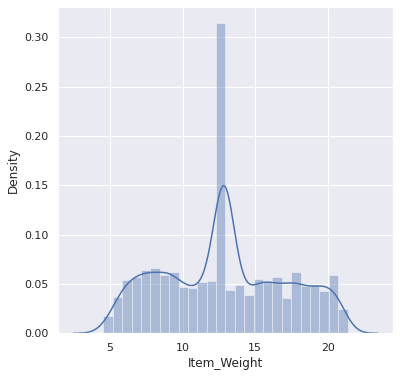

In [40]:
plt.figure(figsize=(6,6))
sns.distplot(flip_kart_data['Item_Weight'])
plt.show()


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



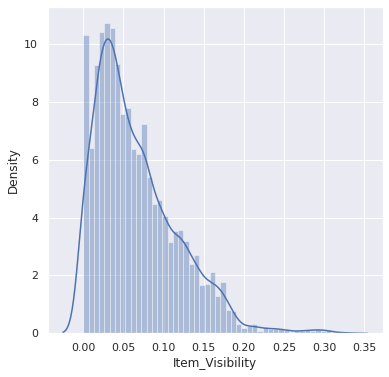

In [41]:
plt.figure(figsize=(6,6))
sns.distplot(flip_kart_data['Item_Visibility'])
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



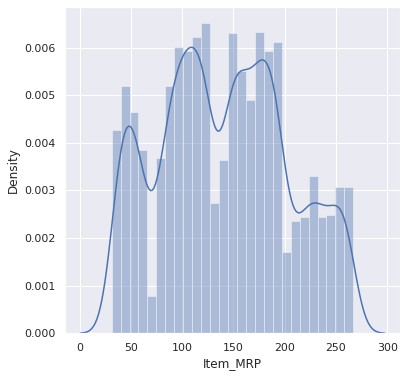

In [42]:
plt.figure(figsize=(6,6))
sns.distplot(flip_kart_data['Item_MRP'])
plt.show()

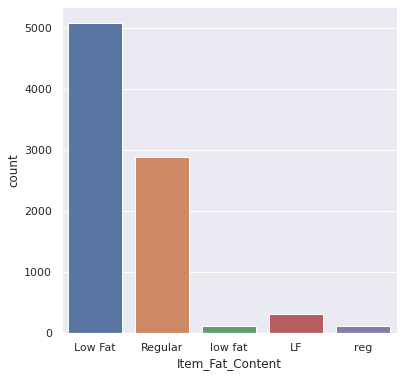

In [43]:
plt.figure(figsize=(6,6))
sns.countplot(x='Item_Fat_Content', data=flip_kart_data)
plt.show()

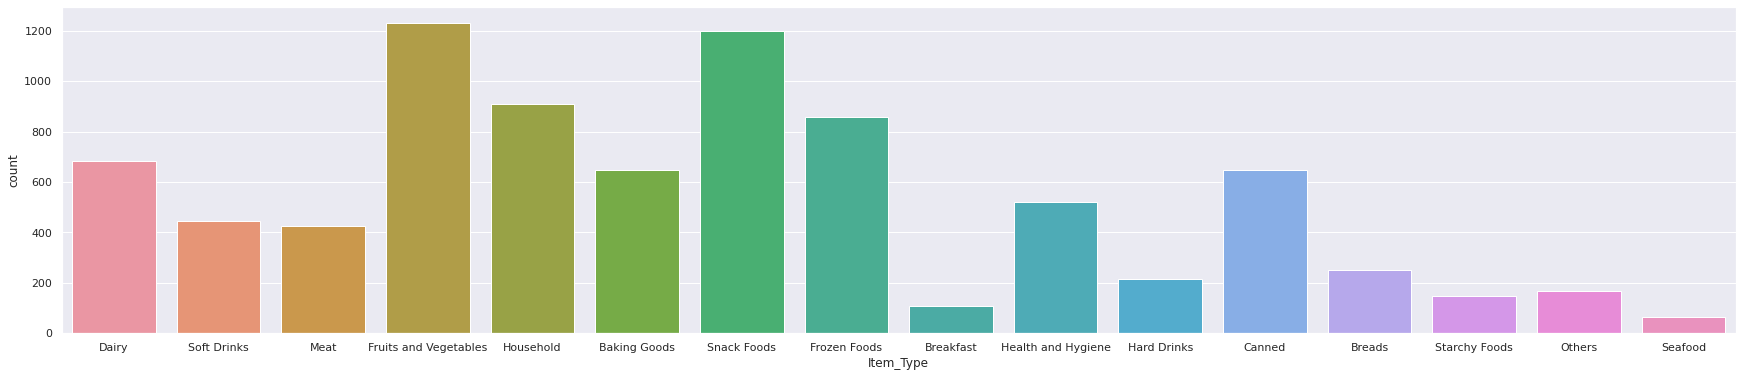

In [44]:
plt.figure(figsize=(30,6))
sns.countplot(x='Item_Type', data=flip_kart_data)
plt.show()

In [45]:
flip_kart_data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Item_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,994.7052


In [46]:
flip_kart_data['Item_Fat_Content'].value_counts()

Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

In [47]:
flip_kart_data.replace({'Item_Fat_Content': {'low fat':'Low Fat','LF':'Low Fat', 'reg':'Regular'}}, inplace=True)

In [48]:
flip_kart_data['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

In [49]:
encoder = LabelEncoder()

In [51]:
flip_kart_data['Item_Identifier'] = encoder.fit_transform(flip_kart_data['Item_Identifier'])

flip_kart_data['Item_Fat_Content'] = encoder.fit_transform(flip_kart_data['Item_Fat_Content'])

flip_kart_data['Item_Type'] = encoder.fit_transform(flip_kart_data['Item_Type'])





In [52]:
flip_kart_data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Item_Sales
0,156,9.30,0,0.016047,4,249.8092,3735.1380
1,8,5.92,1,0.019278,14,48.2692,443.4228
2,662,17.50,0,0.016760,10,141.6180,2097.2700
3,1121,19.20,1,0.000000,6,182.0950,732.3800
4,1297,8.93,0,0.000000,9,53.8614,994.7052


In [55]:
X = flip_kart_data.drop(columns='Item_Sales', axis=1)
Y = flip_kart_data['Item_Sales']

In [56]:
print(X)

      Item_Identifier  Item_Weight  Item_Fat_Content  Item_Visibility  \
0                 156        9.300                 0         0.016047   
1                   8        5.920                 1         0.019278   
2                 662       17.500                 0         0.016760   
3                1121       19.200                 1         0.000000   
4                1297        8.930                 0         0.000000   
...               ...          ...               ...              ...   
8518              370        6.865                 0         0.056783   
8519              897        8.380                 1         0.046982   
8520             1357       10.600                 0         0.035186   
8521              681        7.210                 1         0.145221   
8522               50       14.800                 0         0.044878   

      Item_Type  Item_MRP  
0             4  249.8092  
1            14   48.2692  
2            10  141.6180  
3          

In [57]:
print(Y)

0       3735.1380
1        443.4228
2       2097.2700
3        732.3800
4        994.7052
          ...    
8518    2778.3834
8519     549.2850
8520    1193.1136
8521    1845.5976
8522     765.6700
Name: Item_Sales, Length: 8523, dtype: float64


In [58]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2)

In [59]:
print(X.shape, X_train.shape, X_test.shape)

(8523, 6) (6818, 6) (1705, 6)


In [91]:
regressor = XGBRegressor()

In [92]:
regressor.fit(X_train, Y_train)

[06:11:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor()

In [93]:
training_data_prediction = regressor.predict(X_train)

In [94]:
r2_train = metrics.r2_score(Y_train, training_data_prediction)

In [95]:
print('R Squared value = ', r2_train)

R Squared value =  0.42415180011744025


In [96]:
test_data_prediction = regressor.predict(X_test)

In [97]:
r2_test = metrics.r2_score(Y_test, test_data_prediction)

In [98]:
print('R Squared value = ', r2_test)

R Squared value =  0.3605200955628133


Conclusion:

Hence, we conclude that:

The top product customers are purchasing is 'Clothing', whereas, the top brand is 'black'.

Brands giving highest discounts are 'Rajcrafts', 'Bling', 'Fash Blush' and more.

Learnt how to target active customers and how to know which item will be in trend.

Out of 20,000 products only 620 products have 5 star ratings.

In the months of januray,february, april and may the prices spiked up.

we also see the flipkart grocery and their sale prediction.

**bold text**